In [1]:
import db_helpers as dbh
import db_parse as dbp
import json
import pandas as pd
from pprint import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [ ]:
sns.set(style="whitegrid")

In [2]:
data_dir = "data"
materialization = "hnet"
session = "cookies"
revision = "test"
materialization = "hnet"
do_wipe = False
do_import = False
do_describe = False

In [4]:
conn = dbh.Connection("dos")
if do_describe:
    print(f"Connected to database: {conn.db_name()}")
    conn.describe()
    conn.row_counts()
    conn.db_query("select distinct metric from data")

Connected to database: dos


In [5]:
revision_id = conn.nickname_id("revisions", revision)
materialization_id = conn.nickname_id("materializations", materialization)
session_id = dbh.result_as_value(conn.db_query("select id from sessions where nickname='{}'".format(session)))

In [11]:
df = pd.DataFrame(
    conn.db_query(
    """
    SELECT
        hostname,
        hostnum::int AS Client,
        (settings->>'attack_type') AS attack_type,
        (settings->>'mitigation') AS Mitigation,
        (settings->>'bottleneck_capacity')::int,
        (settings->>'bottleneck_latency')::int,
        (settings->>'client_interval')::float,
        (settings->>'mitigated_attack_type') AS mitigated_attack,
        (settings->>'syn_pow_verifier') AS Verifier,
        (settings->>'n_attackers')::int AS Attackers,
        (settings->>'client_app') AS client_app,
        (settings->>'attacker_busywait')::int AS busywait,
        (settings->>'attacker_cpu_limit')::int AS attacker_cpu_limit,
        metric,
        ub,
        mb,
        ua,
        ma,
        efficacy,
        overhead,
        threat,
        damage,
        efficacy_pct,
        efficacy_pct_threat,
        overhead_pct,
        threat_pct,
        damage_pct
    FROM results
    JOIN experiments ON results.experiment = experiments.id
    JOIN hosts ON results.host = hosts.id
    JOIN sessions ON experiments.session = sessions.id
    WHERE
        (sessions.nickname IN ('cookies'))
    """
    ), columns=["Hostname", "Client", "Attack", "Mitigation", "Bottleneck Capacity", "Bottleneck Latency", "Client Delay", "Mitigated Attack", "Verifier", "Attackers", "Client Application", "Attacker Busywait", "Attacker CPU Limit", "Metric", "UB", "MB", "UA", "MA", "Efficacy", "Overhead", "Threat", "Damage", "Efficacy Percent", "Efficacy Percent Threat", "Overhead Percent", "Threat Percent", "Damage Percent"]
)

In [12]:
mitigation_k_map = {
    'syn_pow_0': 0,
    'syn_pow_8': 8,
    'syn_pow_32': 32,
    'syn_pow_64': 64,
    'syn_pow_256': 256,
    'syn_pow_1024': 1024
}
df["Client/Server k"] = df["Mitigation"].map(mitigation_k_map)

mitigation_map = {
    'syn_pow_0': 'eBPF No-Op',
    'syn_pow_8': 'SYN PoW (k=8)',
    'syn_pow_32':'SYN PoW (k=32)',
    'syn_pow_64': 'SYN PoW (k=64)',
    'syn_pow_256': 'SYN PoW (k=256)',
    'syn_cookies': 'SYN Cookies',
    'syn_pow_8_cookies': 'SYN Cookies + PoW (k=8)',
    'syn_pow_64_cookies': 'SYN Cookies + PoW (k=64)',
    'syn_pad': 'SYN Padding',
    'syn_pad_cookies': 'SYN Cookies + Padding'
}
df["DoS Mitigation"] = df["Mitigation"].map(mitigation_map)

mitigated_attack_k_map = {
    'syn_flood': 0,
    'syn_flood_pow_8': 8,
    'syn_flood_pow_32': 32,
    'syn_flood_pow_64': 64,
    'syn_flood_pow_256': 256,
    'syn_flood_pow_1024': 1024
}
df["Attacker k"] = df["Mitigated Attack"].map(mitigated_attack_k_map)

flood_type_map = {
    'syn_flood': 'Dumb',
    'syn_flood_pow_8': 'Smart',
    'syn_flood_pow_32': 'Smart',
    'syn_flood_pow_64': 'Smart',
    'syn_flood_pow_256': 'Smart',
    'syn_flood_pow_1024': 'Smart',
    'syn_flood_padded': 'Smart'
}
df["Flood Type"] = df["Mitigated Attack"].map(flood_type_map)

client_app_map = {
    'tcp': 'TCP Setup',
    'http_1K': 'HTTP - 1KB',
    'http_1M': 'HTTP - 1MB'
}
df["Application"] = df["Client Application"].map(client_app_map)

client_location_map = {
    0: 'A',
    1: 'A',
    2: 'A',
    3: 'B',
    4: 'B',
    5: 'B',
    6: 'C',
    7: 'C',
    8: 'C',
    9: 'D',
    10: 'D',
    11: 'D',
}
df["Client Subnet"] = df["Client"].map(client_location_map)
df["Client Location"] = df["Client Subnet"].map({
    'A': 'Local',
    'B': 'Remote',
    'C': 'Local',
    'D': 'Remote'
})
# attacker_k_map = {
#     'syn_flood': 0,
#     'syn_flood_pow_8': 8,
#     'syn_flood_pow_32': 32
# }
# df["Attacker k"] = df["Mitigated Attack"].map(attacker_k_map)

verifier_map = {
    's0': 'Server',
    'firewall': 'Firewall',
    'edge_router': 'Edge Routers'
}
df["Verifier Location"] = df["Verifier"].map(verifier_map)

df["Attack Strength"] = df["Attackers"] * 0.01 * df["Attacker CPU Limit"]

# mitigation_map = {
#     'syn_pad': 'SYN Padding',
#     'syn_pow_8': 'SYN PoW (k=8)',
#     'syn_pow_64': 'SYN PoW (k=64)'
# }
# df["Mitigation Approach"] = df["Mitigation"].map(verifier_map)

In [13]:
for col in df:
    if col not in ['UB', 'UA', 'MB', 'MA', 'Threat', 'Damage', 'Efficacy', 'Overhead', 'Threat Percent', 'Damage Percent', 'Efficacy Percent', 'Efficacy Percent Threat', 'Overhead Percent']:
        print("{}: {}".format(col, df[col].unique()))

Hostname: ['c1' 'c3' 'c4' 'c2' 'c7' 'c0' 'c11' 'c6' 'c8' 'c10' 'c5' 'c9']
Client: [ 1  3  4  2  7  0 11  6  8 10  5  9]
Attack: ['syn_flood']
Mitigation: ['syn_cookies']
Bottleneck Capacity: [1000  500  100]
Bottleneck Latency: [1]
Client Delay: [0.]
Mitigated Attack: ['syn_flood']
Verifier: ['s0']
Attackers: [1 3 4 2]
Client Application: ['http_1K' 'tcp' 'http_1M']
Attacker Busywait: [0]
Attacker CPU Limit: [ 10 100]
Metric: ['Transaction Duration' 'Transaction Status' 'Transactions per Second']
Client/Server k: [nan]
DoS Mitigation: ['SYN Cookies']
Attacker k: [0]
Flood Type: ['Dumb']
Application: ['HTTP - 1KB' 'TCP Setup' 'HTTP - 1MB']
Client Subnet: ['A' 'B' 'C' 'D']
Client Location: ['Local' 'Remote']
Verifier Location: ['Server']
Attack Strength: [0.1 3.  0.4 4.  2.  0.2 1.  0.3]


In [14]:
df_plt = df.loc[
    (df['Metric'] == 'Transactions per Second') &
    # (df['Verifier'] == 'edge_router') &
    # (df['Client Application'] == 'tcp') & 
    # (df['Mitigation'] == 'syn_pad') &
    # (df['Bottleneck Capacity'].isin(1000, 100) &
    # (df['Mitigated Attack'] != 'syn_flood') &
    (df['Attacker CPU Limit'] == 10)
    # (df['Attacker Busywait'] == 10000)
    # (df['Attackers'] == 1) &
    # (df['Client'].isin([3, 4, 5, 9, 10, 11]))
    # (
    #     ((df['Mitigation'] == 'syn_pow_64') & (df['Mitigated Attack'] == 'syn_flood')) |
    #     ((df['Mitigation'] == 'syn_pad') & (df['Mitigated Attack'] == 'syn_flood_padded')) |
    #     ((df['Mitigation'] == 'syn_cookies') & (df['Mitigated Attack'] == 'syn_flood'))
    # )
]

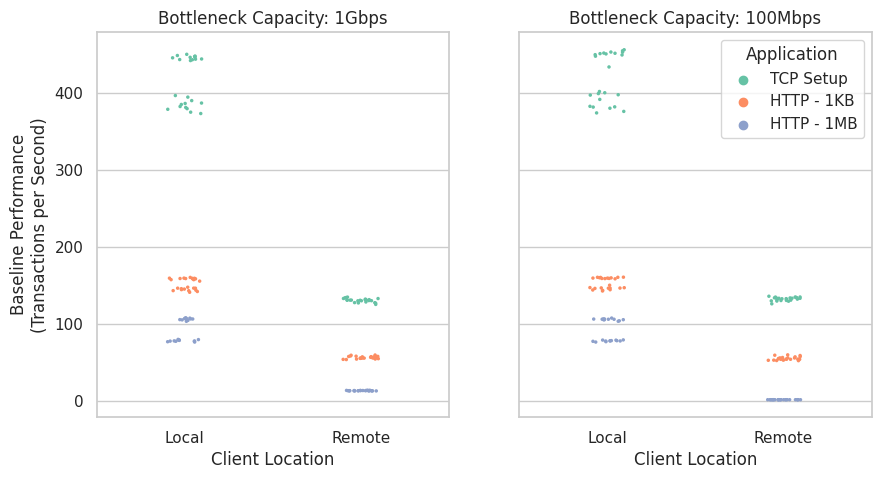

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.stripplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 1000)],
    ax=axes[0],
    x='Client Location',
    y='UB',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    alpha=1,
    marker='.'
)

sns.stripplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 100)],
    ax=axes[1],
    x='Client Location',
    y='UB',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    alpha=1,
    marker='.'
)

axes[0].get_legend().remove()
axes[0].set_title('Bottleneck Capacity: 1Gbps')
axes[1].set_title('Bottleneck Capacity: 100Mbps')
# plt.ylim(bottom=0)
axes[0].set_ylabel('Baseline Performance\n(Transactions per Second)')
plt.show()

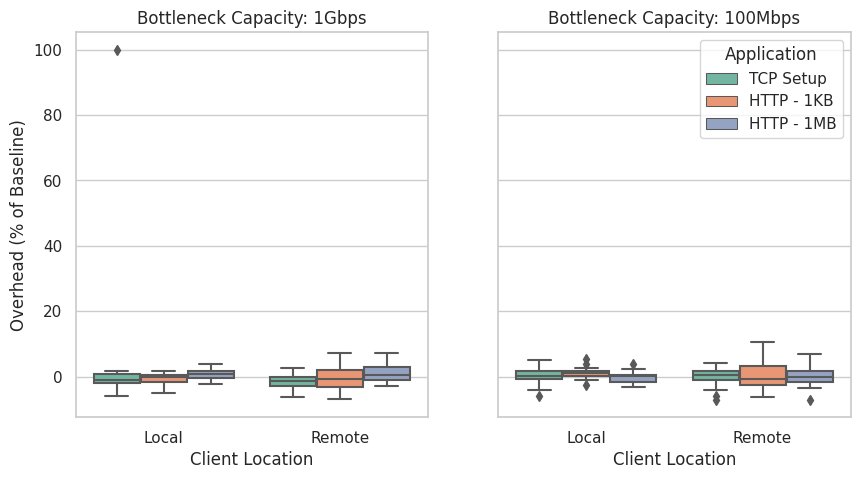

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.boxplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 1000)],
    ax=axes[0],
    x='Client Location',
    y='Overhead Percent',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
)

sns.boxplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 100)],
    ax=axes[1],
    x='Client Location',
    y='Overhead Percent',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
)

axes[0].get_legend().remove()
axes[0].set_title('Bottleneck Capacity: 1Gbps')
axes[1].set_title('Bottleneck Capacity: 100Mbps')
# plt.ylim(bottom=0)
axes[0].set_ylabel('Overhead (% of Baseline)')
axes[1].set_ylabel('')
plt.show()

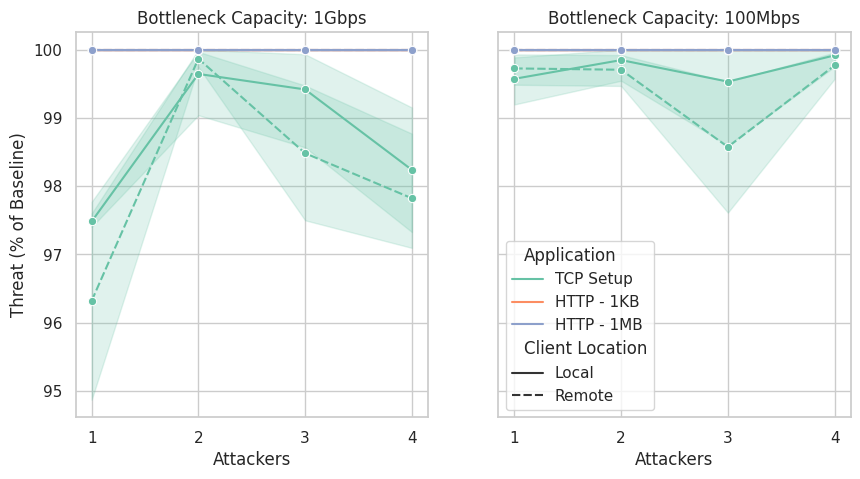

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.lineplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 1000)],
    ax=axes[0],
    x='Attackers',
    y='Threat Percent',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    style='Client Location',
    marker='o'
)

sns.lineplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 100)],
    ax=axes[1],
    x='Attackers',
    y='Threat Percent',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    style='Client Location',
    marker='o'
)

axes[0].get_legend().remove()
axes[0].set_title('Bottleneck Capacity: 1Gbps')
axes[1].set_title('Bottleneck Capacity: 100Mbps')
# plt.ylim(bottom=0)
axes[0].set_ylabel('Threat (% of Baseline)')
axes[1].set_ylabel('')
axes[0].set_xticks([1, 2, 3, 4])
axes[1].set_xticks([1, 2, 3, 4])

plt.show()

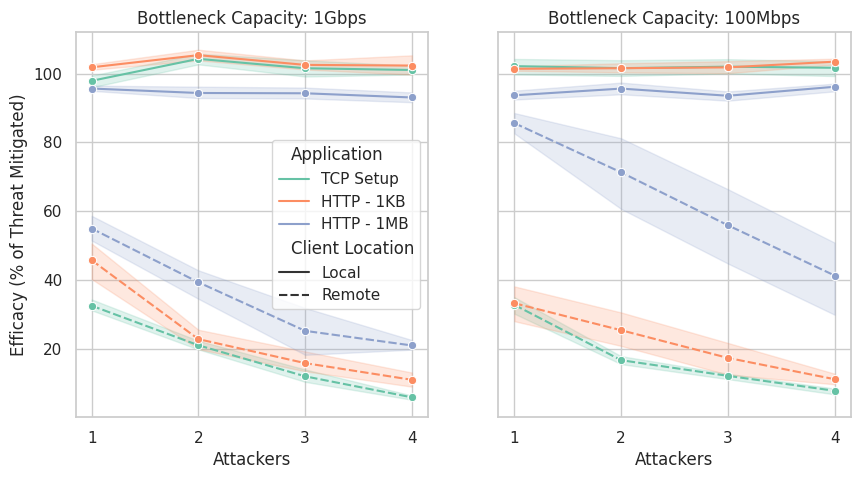

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.lineplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 1000)],
    ax=axes[0],
    x='Attackers',
    y='Efficacy Percent Threat',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    style='Client Location',
    marker='o'
)

sns.lineplot(
    data=df_plt.loc[(df['Bottleneck Capacity'] == 100)],
    ax=axes[1],
    x='Attackers',
    y='Efficacy Percent Threat',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2',
    style='Client Location',
    marker='o'
)

axes[1].get_legend().remove()
axes[0].set_title('Bottleneck Capacity: 1Gbps')
axes[1].set_title('Bottleneck Capacity: 100Mbps')
# plt.ylim(bottom=0)
axes[0].set_ylabel('Efficacy (% of Threat Mitigated)')
axes[1].set_ylabel('')
axes[0].set_xticks([1, 2, 3, 4])
axes[1].set_xticks([1, 2, 3, 4])

plt.show()

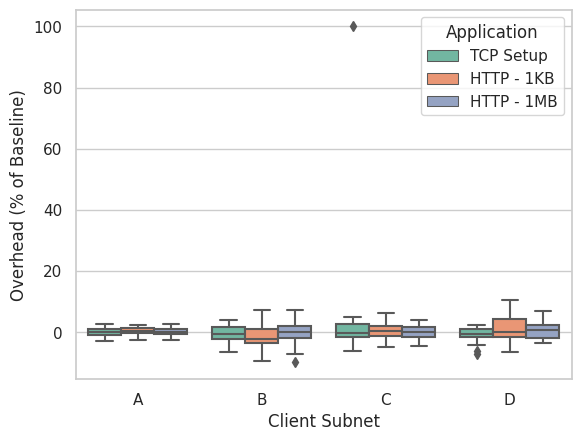

In [20]:
sns.boxplot(
    data=df_plt,
    x='Client Subnet',
    # y='MB',
    y='Overhead Percent',
    hue='Application',
    hue_order=['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    #hue_order = ['SYN Cookies', 'SYN Padding', 'SYN Cookies + Padding'],
    palette='Set2'
    
)
plt.ylabel("Overhead (% of Baseline)")
plt.show()

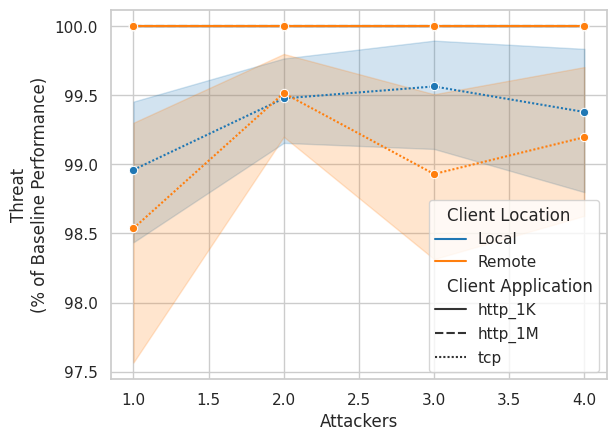

In [21]:
sns.lineplot(
    data=df_plt,
    hue='Client Location',
    # y='MB',
    y="Threat Percent",
    x='Attackers',
    style='Client Application',
    marker='o',
    # hue_order = ['SYN Cookies', 'SYN Padding', 'SYN Cookies + Padding'],
    palette='tab10'
)
plt.xlabel("Attackers")
plt.ylabel("Threat\n(% of Baseline Performance)")
plt.show()

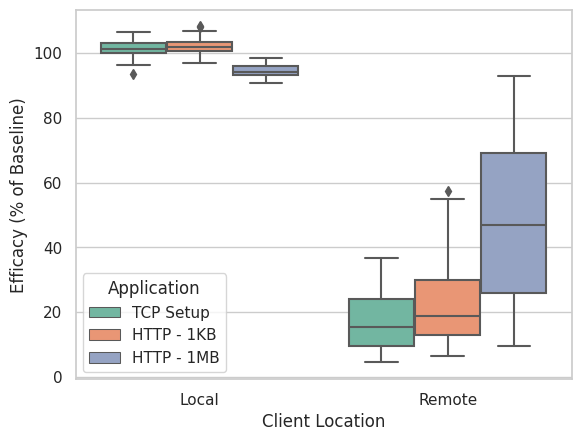

In [22]:
sns.boxplot(
    data=df_plt,
    hue='Application',
    # y='MB',
    y="Efficacy Percent",
    x='Client Location',
    hue_order = ['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='Set2'
)
plt.ylabel("Efficacy (% of Baseline)")
plt.show()

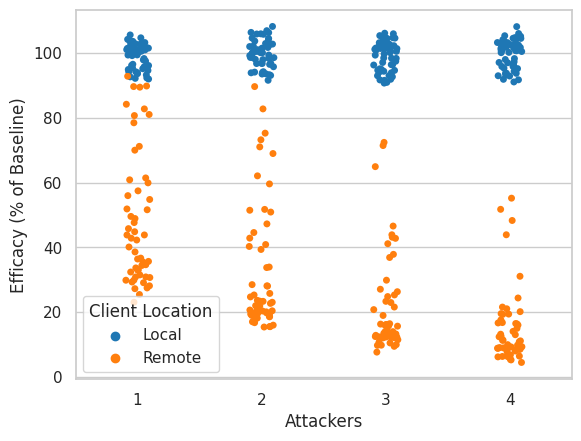

In [23]:
# Overhead by Mitigation and Client Application
sns.stripplot(
    data=df_plt,
    hue='Client Location',
    # y='MB',
    y="Efficacy Percent",
    x='Attackers',
    # hue_order = ['TCP Setup', 'HTTP - 1KB', 'HTTP - 1MB'],
    palette='tab10',
)
plt.ylabel("Efficacy (% of Baseline)")
plt.show()